In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from motor.motor_asyncio import AsyncIOMotorClient
from pymongo.server_api import ServerApi
import numpy as np
import sklearn.cross_decomposition
import sklearn.linear_model
import seaborn

import sp_project.data_preparation.db_entsoe as entsoeData
import sp_project.data_preparation.db_openweather_historic as openweatherData
import sp_project.data_preparation.db_wetter2 as wetter2Data

from sp_project.data_preparation.model import total_daily_solarpower

%matplotlib inline

<b>Units:</b><br>
temperature : celsius<br>
rain : mm<br>
wind : m/s<br>
cloud : percent<br>

In [3]:
df_energy_raw = await entsoeData.extract_energy_data_raw()
df_energy_daily = await entsoeData.extract_energy_data_daily()
df_w2_weather_daily = await wetter2Data.extract_data_daily()
df_w2_heating_demand = await wetter2Data.extract_heatingdemand()
df_w2_windpower = await wetter2Data.extract_windpower()

### Solar iradiation, given date, time and geographic latitude

sin(θ) = sin(δ) * sin(φ) + cos(δ) * cos(φ) * cos(H)

Where:

 - θ is the angle of the sun's rays relative to the horizontal (in degrees)
 - δ is the solar declination angle (in degrees)
 - φ is the latitude of the location (in degrees)
 - H is the hour angle (in degrees)
 
The solar declination angle can be calculated using the following formula:

δ = 23.45 * sin[360/365 * (284 + N)]

Where N is the day of the year (starting from 1 on January 1st). This formula gives the declination angle in degrees.

Once the angle of the sun's rays is known, the solar power can be estimated using the following formula:

P = A * I * sin(θ)

Where:

 - P is the solar power (in watts)
 - A is the surface area of the solar panel (in square meters)
 - I is the intensity of the solar radiation (in watts per square meter)

In [45]:
cloudiness = df_w2_weather_daily.clouds
date = cloudiness.index
lat = 47

solar_power = total_daily_solarpower(date, lat) * (100 - cloudiness)/100

<AxesSubplot:xlabel='date'>

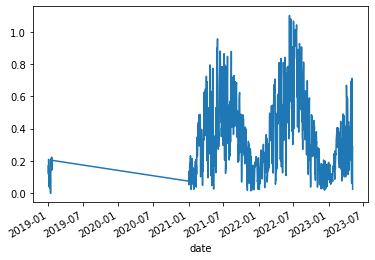

In [46]:
solar_power.plot()

In [47]:
lat = 47

solar_power = total_daily_solarpower(
    df_w2_weather_daily.index,
    lat
) * (100 - df_w2_weather_daily.clouds)/100

In [48]:
input_features = []

input_features.append(df_w2_heating_demand.heating_demand)
input_features.append(df_w2_windpower.windpower)
input_features.append(df_w2_weather_daily.rain)
input_features.append(solar_power.rename("solar_power"))

input_features = pd.concat(input_features, axis="columns")
input_features = input_features.loc["2021-01-01":,:]
input_features

,heating_demand,windpower,rain,solar_power
date,,,,
2021-01-01 00:00:00+00:00,19.450073,4.649711,0.135892,0.076101
2021-01-02 00:00:00+00:00,19.371462,5.982797,0.072484,0.097275
2021-01-03 00:00:00+00:00,19.525786,2.387248,0.107154,0.052700
2021-01-04 00:00:00+00:00,20.982469,2.972581,0.004638,0.136447
2021-01-05 00:00:00+00:00,21.139230,2.973106,0.004796,0.119529
...,...,...,...,...
2023-05-02 00:00:00+00:00,9.676389,6.620124,0.059722,0.417493
2023-05-03 00:00:00+00:00,9.712500,4.695109,0.001389,0.712532
2023-05-04 00:00:00+00:00,8.515278,1.878311,0.083333,0.138074


In [49]:
target_features = await entsoeData.extract_energy_data_daily()
target_features.head()

,wind,solar,nuclear,water_reservoir,water_river,water_pump,total
date,,,,,,,
2021-01-01 00:00:00+00:00,4.041667,2.208333,3001.708333,593.291667,139.291667,234.833333,3975.375000
2021-01-02 00:00:00+00:00,1.125000,3.541667,3001.875000,655.708333,136.916667,207.875000,4007.041667
2021-01-03 00:00:00+00:00,2.166667,20.041667,3003.750000,552.583333,127.041667,242.458333,3948.041667
2021-01-04 00:00:00+00:00,2.625000,13.458333,3004.583333,1885.875000,152.291667,1030.833333,6089.666667
2021-01-05 00:00:00+00:00,0.333333,15.500000,2996.541667,1987.000000,156.291667,1239.791667,6395.458333


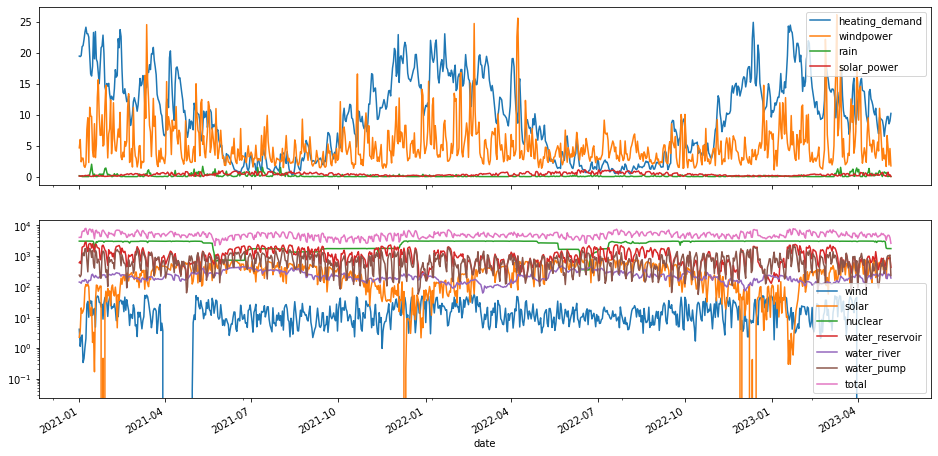

In [50]:
fig,axes = plt.subplots(2,1,figsize=(16,8),sharex=True)

ax = axes[0]
input_features.plot(ax=ax)
ax = axes[1]
target_features.plot(ax=ax)
ax.set_yscale("log")

In [56]:
valid_input_features_ts = input_features.dropna(axis="index", how='any').index
valid_target_features_ts = target_features.dropna(axis="index", how='any').index

joined_index = valid_input_features_ts.intersection(valid_target_features_ts)

X = input_features.solar_power[joined_index].values[:,None]  # values converts it into a numpy array
Y = target_features.solar[joined_index].values[:,None]  # values converts it into a numpy array
linear_regressor = sklearn.linear_model.LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

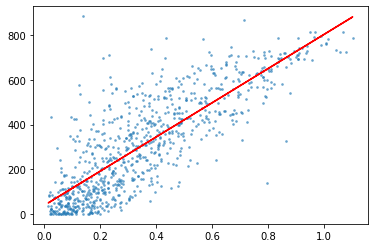

In [62]:
plt.scatter(X, Y, alpha=0.5, s=3)
plt.plot(X, Y_pred, color='red')
plt.show()

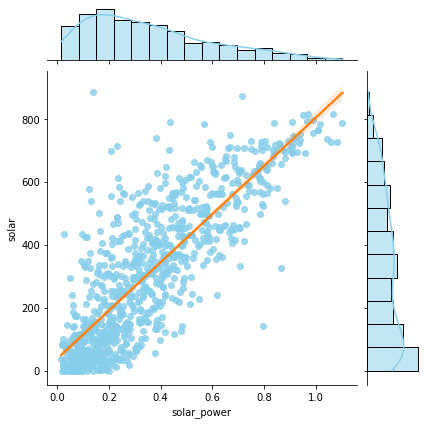

In [96]:
seaborn.jointplot(
    x=input_features.solar_power, 
    y=target_features.solar,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

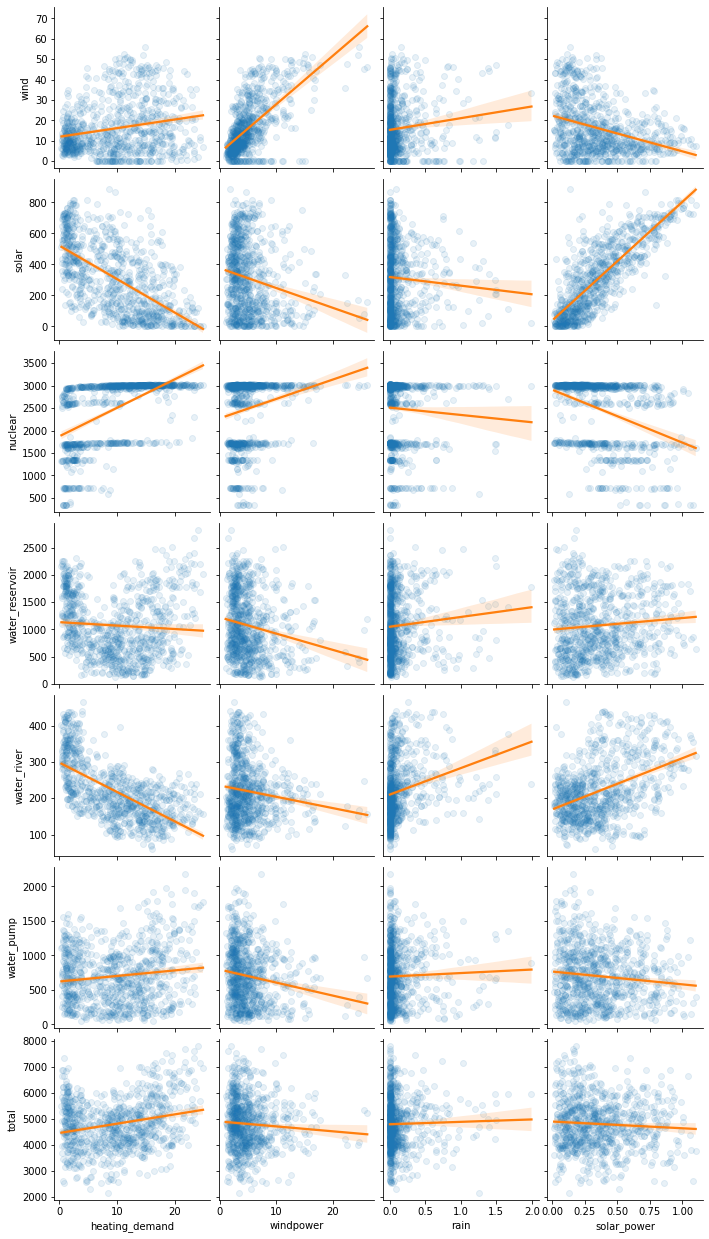

In [97]:
seaborn.pairplot(
    data=pd.concat([input_features, target_features],axis="columns"),
    x_vars=input_features.columns,
    y_vars=target_features.columns,
    kind="reg",
    plot_kws=dict(
        scatter_kws=dict(
            color="tab:blue",
            alpha=0.1,
        ),
        line_kws=dict(color='tab:orange'),
    )
)

In [98]:
input_features_weekly = input_features.resample('W').mean()
target_features_weekly = target_features.resample('W').mean()

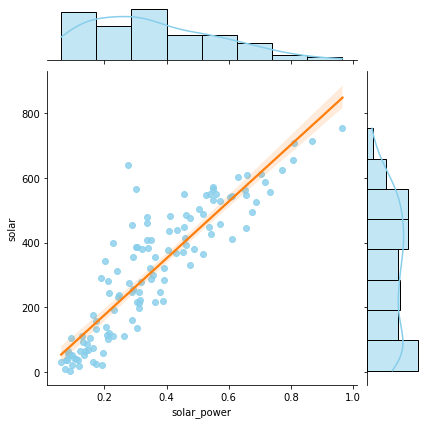

In [99]:
seaborn.jointplot(
    x=input_features_weekly.solar_power, 
    y=target_features_weekly.solar,  
    kind="reg",
    color="skyblue",
    joint_kws={'line_kws':{'color':'tab:orange'}},
)

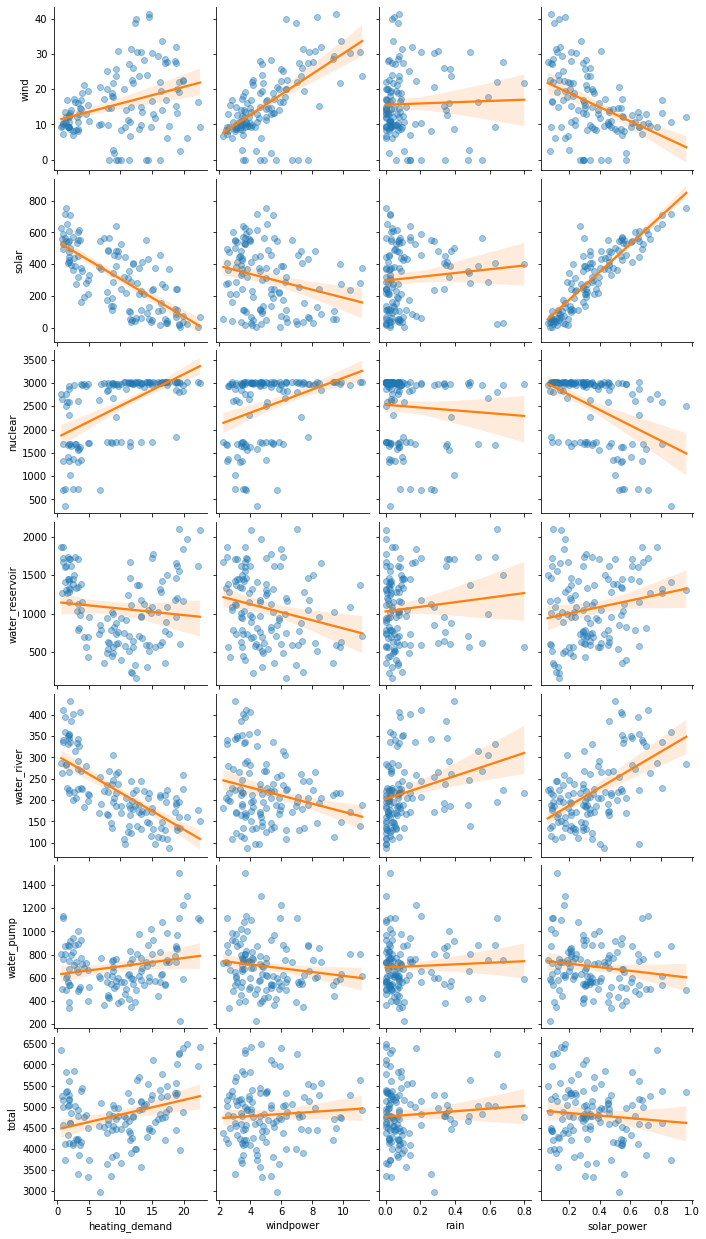

In [101]:
seaborn.pairplot(
    data=pd.concat([input_features_weekly, target_features_weekly],axis="columns"),
    x_vars=input_features_weekly.columns,
    y_vars=target_features_weekly.columns,
    kind="reg",
    plot_kws=dict(
        scatter_kws=dict(
            color="tab:blue",
            alpha=0.4,
        ),
        line_kws=dict(color='tab:orange'),
    )
)

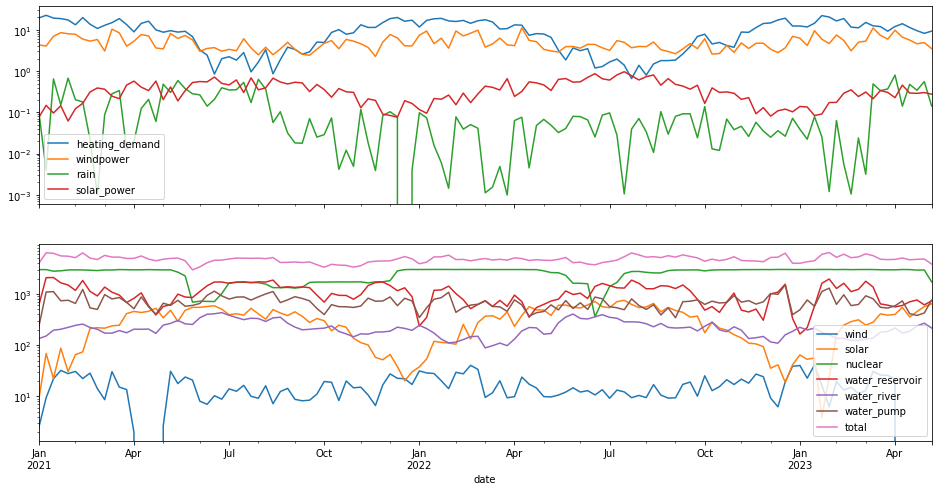

In [51]:
fig,axes = plt.subplots(2,1,figsize=(16,8),sharex=True)

ax = axes[0]
input_features_weekly.plot(ax=ax)
ax.set_yscale("log")

ax = axes[1]
target_features_weekly.plot(ax=ax)
ax.set_yscale("log")

In [121]:
valid_input_features_ts = input_features_weekly.dropna(axis="index", how='any').index
valid_target_features_ts = target_features_weekly.dropna(axis="index", how='any').index

joined_index = valid_input_features_ts.intersection(valid_target_features_ts)



pls2 = sklearn.cross_decomposition.PLSRegression(n_components=4)

# Data for prediction (fitter can not use the columns-name, so we use seperate variables)
input_features_columns = input_features_weekly.columns
target_features_columns = target_features_weekly.columns
pls2 = pls2.fit(
    input_features_weekly.loc[joined_index,:], 
    target_features_weekly.loc[joined_index,:],
)

In [126]:
import pickle
# Short-term-Storage of our model

with open("prediction-model.pickle", "wb") as fh:
    pickle.dump(dict(
        regressor = pls2,
        input_columns = input_features_columns,
        prediction_columns = target_features_columns,
    ), fh)

In [122]:
prediction = pls2.predict(input_features.loc[:,input_features_columns])
prediction = pd.DataFrame(prediction, index = input_features.index,columns=target_features_columns)
prediction_weekly = prediction.resample('W').mean()

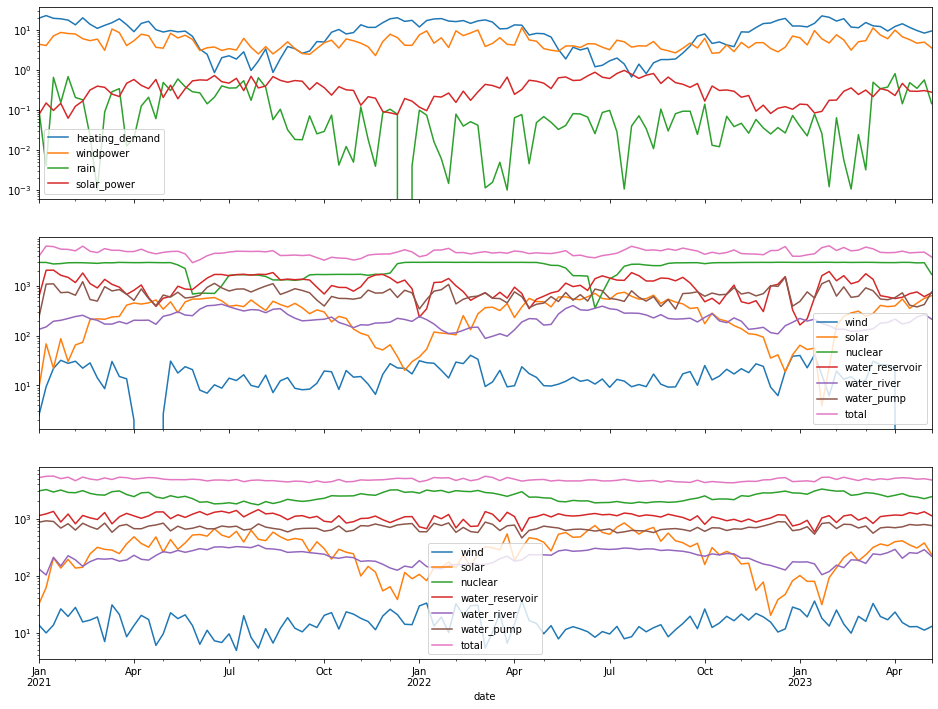

In [123]:
fig,axes = plt.subplots(3,1,figsize=(16,12),sharex=True)

ax = axes[0]
input_features_weekly.plot(ax=ax)
ax.set_yscale("log")

ax = axes[1]
target_features_weekly.plot(ax=ax)
ax.set_yscale("log")

ax = axes[2]
prediction_weekly.plot(ax=ax)
ax.set_yscale("log")

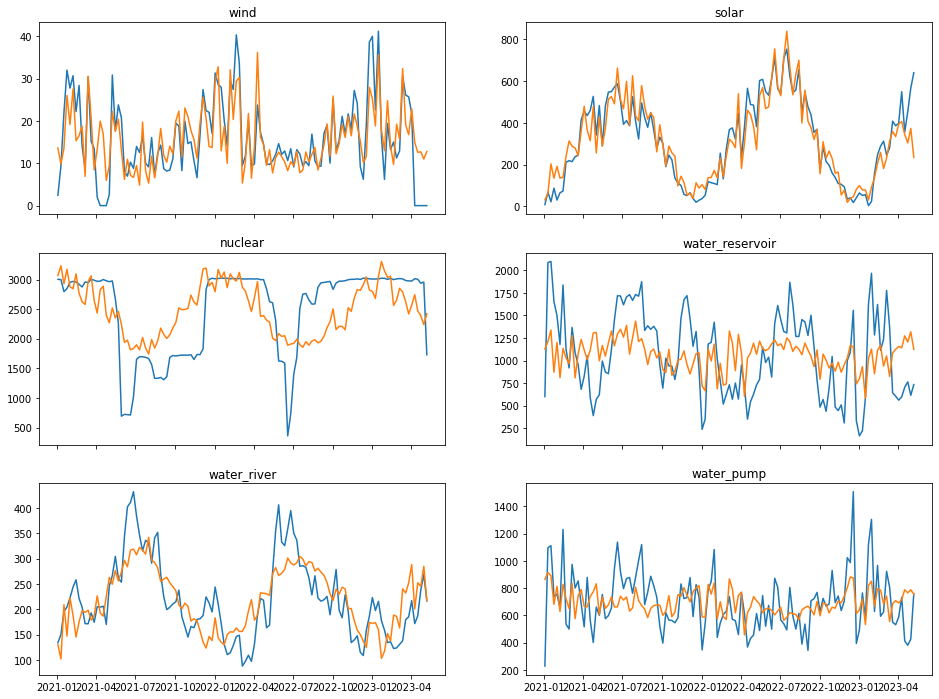

In [124]:
fig,axes = plt.subplots(3,2,figsize=(16,12),sharex=True)

for ax, col in zip(axes.ravel(),target_features.columns):
    ax.plot(target_features_weekly.loc[:,col])
    ax.plot(prediction_weekly.loc[:,col])
    ax.set_title(col)